In [ ]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer

In [ ]:
model = TFAutoModel.from_pretrained("bert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
from datasets import load_dataset
emotions = load_dataset('SetFit/emotion')


Repo card metadata block was not found. Setting CardData to empty.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [ ]:

emotions_encoded.set_format('tf',
                            columns=['input_ids', 'attention_mask', 'token_type_ids', 'label'])
BATCH_SIZE = 64

def order(inp):
    data = list(inp.values())
    return {
        'input_ids': data[1],
        'attention_mask': data[2],
        'token_type_ids': data[3]
    }, data[0]

train_dataset = tf.data.Dataset.from_tensor_slices(emotions_encoded['train'][:])
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(1000)
train_dataset = train_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(emotions_encoded['test'][:])
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
inp, out = next(iter(train_dataset))
print(inp, '\n\n', out)

{'input_ids': <tf.Tensor: shape=(64, 87), dtype=int64, numpy=
array([[  101, 10047,  2025, ...,     0,     0,     0],
       [  101,  1045,  2514, ...,     0,     0,     0],
       [  101,  1045,  2253, ...,     0,     0,     0],
       ...,
       [  101,  1045,  2211, ...,     0,     0,     0],
       [  101,  1045,  2079, ...,     0,     0,     0],
       [  101,  1045,  2633, ...,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(64, 87), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'token_type_ids': <tf.Tensor: shape=(64, 87), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>} 

 tf.Tensor(
[1 0 1 1 3 2 4 4 1 1 0 0 1 

In [ ]:
class BERTForClassification(tf.keras.Model):

    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.bert(inputs)[1]
        return self.fc(x)

In [ ]:
classifier = BERTForClassification(model, num_classes=6)

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
history = classifier.fit(
    train_dataset,
    epochs=3
)


Epoch 1/3
250/250 [==============================] - 322s 1s/step - loss: 1.1838 - accuracy: 0.5524
Epoch 2/3
250/250 [==============================] - 278s 1s/step - loss: 0.2944 - accuracy: 0.8951
Epoch 3/3
250/250 [==============================] - 278s 1s/step - loss: 0.1606 - accuracy: 0.9338


In [ ]:
classifier.evaluate(test_dataset)

32/32 [==============================] - 14s 273ms/step - loss: 0.1803 - accuracy: 0.9220


[0.18034300208091736, 0.921999990940094]

32/32 - 9s - loss: 0.1803 - accuracy: 0.9220 - 9s/epoch - 282ms/step
Pre-fine-tuning Loss: 0.18034300208091736, Accuracy: 0.921999990940094
Epoch 1/3
250/250 [==============================] - 289s 1s/step - loss: 0.1158 - accuracy: 0.9475 - val_loss: 0.1724 - val_accuracy: 0.9230
Epoch 2/3
250/250 [==============================] - 288s 1s/step - loss: 0.0992 - accuracy: 0.9530 - val_loss: 0.1757 - val_accuracy: 0.9215
Epoch 3/3
250/250 [==============================] - 287s 1s/step - loss: 0.0878 - accuracy: 0.9603 - val_loss: 0.1723 - val_accuracy: 0.9260
32/32 - 9s - loss: 0.1723 - accuracy: 0.9260 - 9s/epoch - 276ms/step
Post-fine-tuning Loss: 0.1722925901412964, Accuracy: 0.9259999990463257


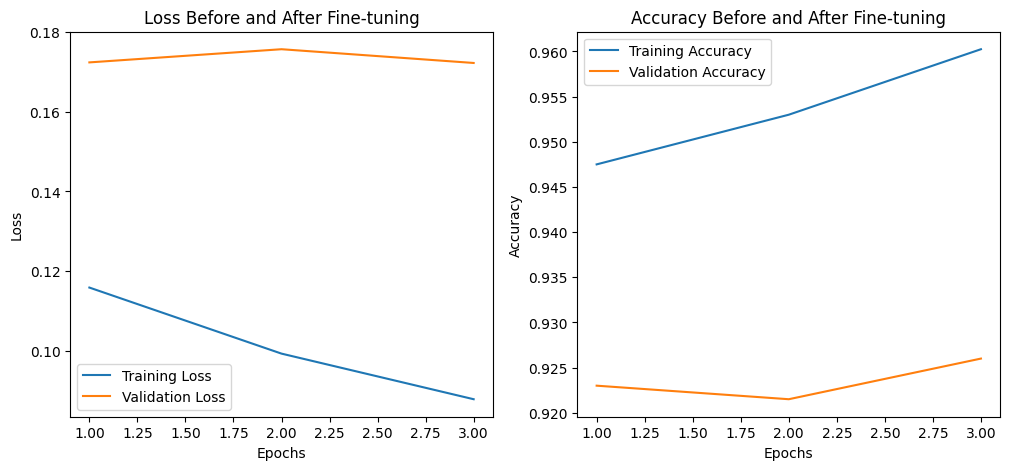

In [ ]:
import matplotlib.pyplot as plt

pre_finetune_loss, pre_finetune_accuracy = classifier.evaluate(test_dataset, verbose=2)
print(f"Pre-fine-tuning Loss: {pre_finetune_loss}, Accuracy: {pre_finetune_accuracy}")

history = classifier.fit(train_dataset, validation_data=test_dataset, epochs=3)

post_finetune_loss, post_finetune_accuracy = classifier.evaluate(test_dataset, verbose=2)
print(f"Post-fine-tuning Loss: {post_finetune_loss}, Accuracy: {post_finetune_accuracy}")

epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Loss Before and After Fine-tuning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Before and After Fine-tuning')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
